In [1]:
import torch
from transformers import AutoImageProcessor, ViTForImageClassification, AutoModelForImageClassification
from peft import PeftConfig, PeftModel
import os 
from PIL import Image
import requests

/home/vasim/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
classes = ['chihuahua', 'newfoundland', 'english setter', 'Persian', 'yorkshire terrier', 'Maine Coon', 'boxer', 'leonberger', 'Birman', 'staffordshire bull terrier', 'Egyptian Mau', 'shiba inu', 'wheaten terrier', 'miniature pinscher', 'american pit bull terrier', 'Bombay', 'British Shorthair', 'german shorthaired', 'american bulldog', 'Abyssinian', 'great pyrenees', 'Siamese', 'Sphynx', 'english cocker spaniel', 'japanese chin', 'havanese', 'Russian Blue', 'saint bernard', 'samoyed', 'scottish terrier', 'keeshond', 'Bengal', 'Ragdoll', 'pomeranian', 'beagle', 'basset hound', 'pug']

label2id = {c:idx for idx,c in enumerate(classes)}
id2label = {idx:c for idx,c in enumerate(classes)}

model_name = "vit-base-patch16-224"
model_checkpoint = f"google/{model_name}"

repo_name = f"md-vasim/{model_name}-finetuned-lora-oxfordPets"

config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the Lora model
inference_model = PeftModel.from_pretrained(model, repo_name)
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


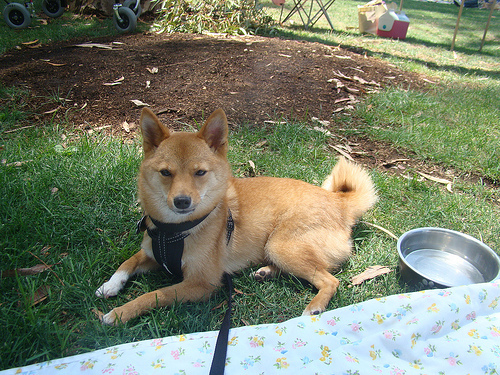

In [3]:
url = "https://huggingface.co/datasets/alanahmet/LoRA-pets-dataset/resolve/main/shiba_inu_136.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [6]:
def inference(image):
    if isinstance(image, str):
        image = Image.open(requests.get(image, stream=True).raw)
    elif isinstance(image, Image):
        image = image 
    
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")
    with torch.no_grad():
        outputs = inference_model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    result = inference_model.config.id2label[predicted_class_idx]
    return result 

In [7]:
inference("https://huggingface.co/datasets/alanahmet/LoRA-pets-dataset/resolve/main/shiba_inu_136.jpg")

'shiba inu'